# Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load and process data

In [4]:
# Load the data from the files
training_data = np.load('training/training_data.npy')
valid_periods = np.load('training/valid_periods.npy')
categories = np.load('training/categories.npy')

training_data.shape, valid_periods.shape, categories.shape

((48000, 2776), (48000, 2), (48000,))

In [5]:
import numpy as np

# Determine the maximum length among all sequences
max_length = max(end_idx - start_idx for start_idx, end_idx in valid_periods)

# Pad all sequences to the maximum length
processed_data = []
for i in range(len(training_data)):
    start_idx, end_idx = valid_periods[i]
    sequence = training_data[i, start_idx:end_idx]

    # Pad the sequence to the maximum length
    padded_sequence = np.pad(sequence, (0, max_length - len(sequence)))

    processed_data.append(padded_sequence)

# Convert the list of sequences to a NumPy array
processed_data = np.array(processed_data)

np.save('processed_data.npy', processed_data)



In [6]:
training_data = np.load('training/processed_data.npy')

In [7]:
# Convert training_data and categories to DataFrame
data_df = pd.DataFrame(training_data, columns=[f'Timestep_{i+1}' for i in range(training_data.shape[1])])
categories_df = pd.DataFrame(categories, columns=['Category'])

# Concatenate DataFrames along the columns
df = pd.concat([data_df, categories_df], axis=1)

# Display the resulting DataFrame
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2777 entries, Timestep_1 to Category
dtypes: float64(2776), object(1)
memory usage: 1017.0+ MB


,Timestep_1,Timestep_2,Timestep_3,Timestep_4,Timestep_5,Timestep_6,Timestep_7,Timestep_8,Timestep_9,Timestep_10,...,Timestep_2767,Timestep_2768,Timestep_2769,Timestep_2770,Timestep_2771,Timestep_2772,Timestep_2773,Timestep_2774,Timestep_2775,Timestep_2776
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,...,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,0.294617,0.296570,0.311277,0.312676,0.315905,0.327528,0.324596,0.323519,0.326198,0.324225,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000006,0.000006,0.000006,0.000005
std,0.313868,0.309717,0.316246,0.316806,0.308752,0.312038,0.312138,0.310601,0.308453,0.306235,...,0.001105,0.001194,0.001158,0.001136,0.001151,0.001191,0.001223,0.001242,0.001232,0.001197
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017053,0.026143,0.036552,0.041840,0.048021,0.054732,0.053503,0.053497,0.059964,0.062067,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.164482,0.166667,0.179424,0.177778,0.189224,0.204628,0.198634,0.199197,0.202721,0.200518,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.530799,0.531936,0.558958,0.557046,0.563917,0.585731,0.580660,0.577783,0.579325,0.570832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.242176,0.261673,0.253678,0.248855,0.252103,0.260920,0.267974,0.272139,0.269904,0.262239


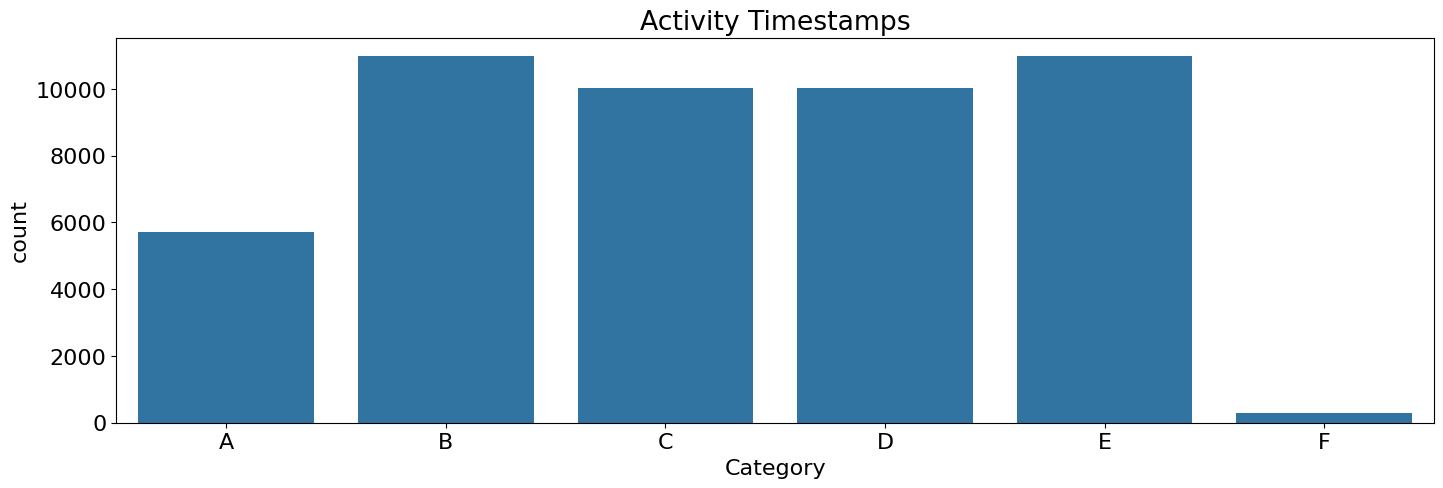

In [8]:
# Inspect activities timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'Category', data = df, order = sorted(df['Category'].unique()))
plt.title('Activity Timestamps')
plt.show()

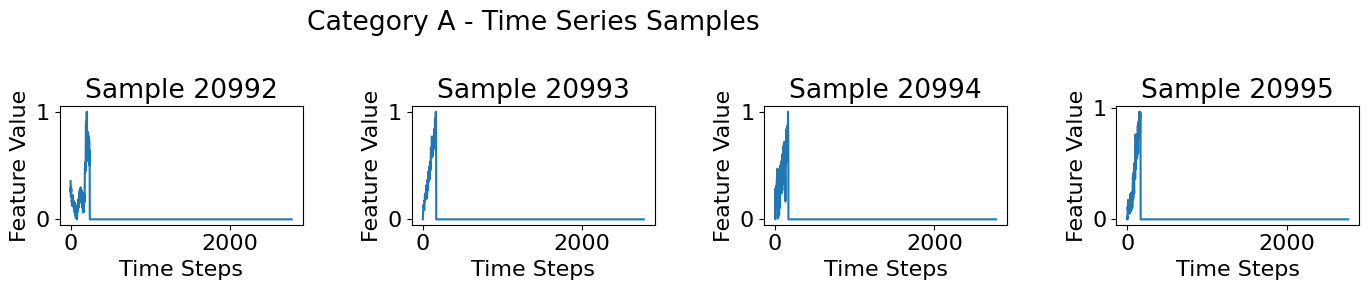

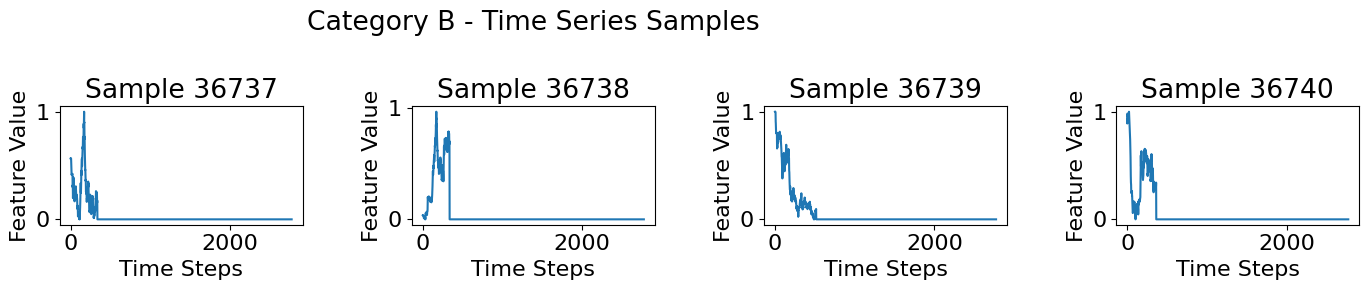

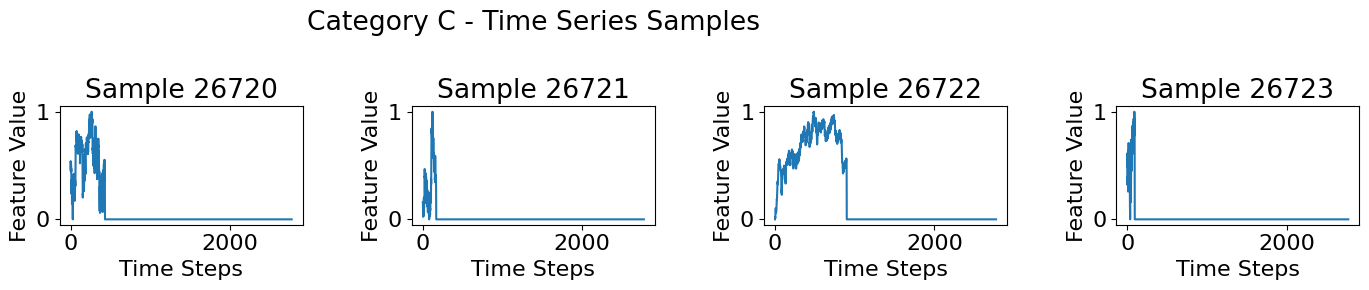

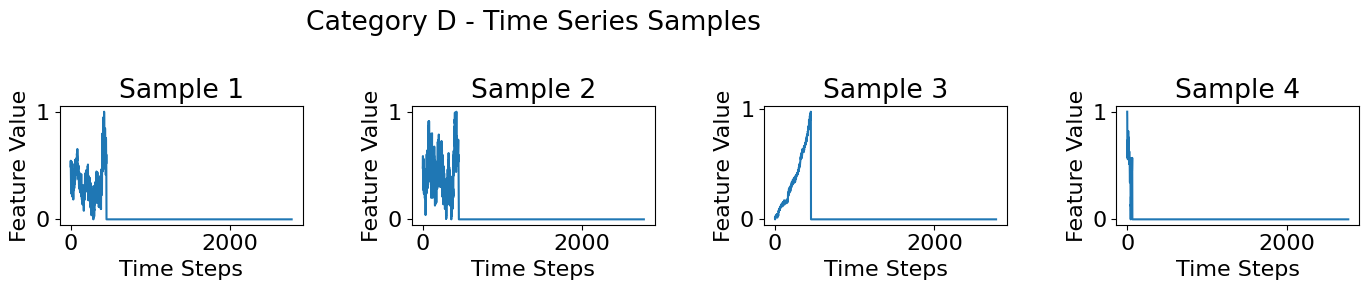

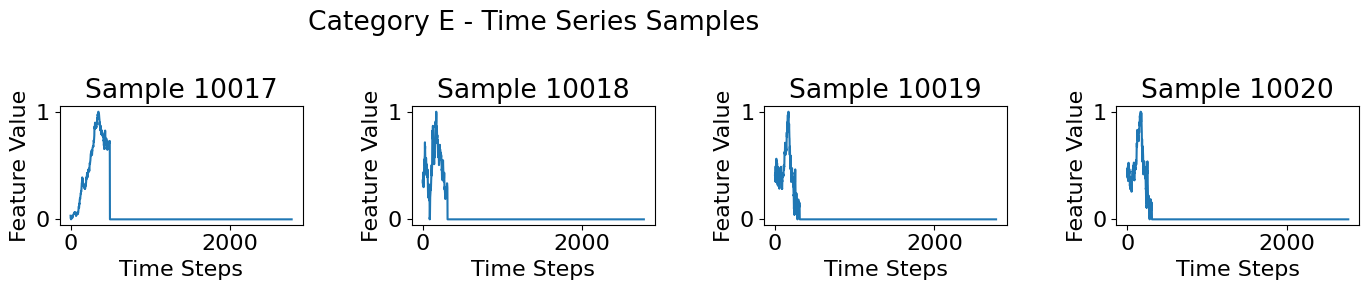

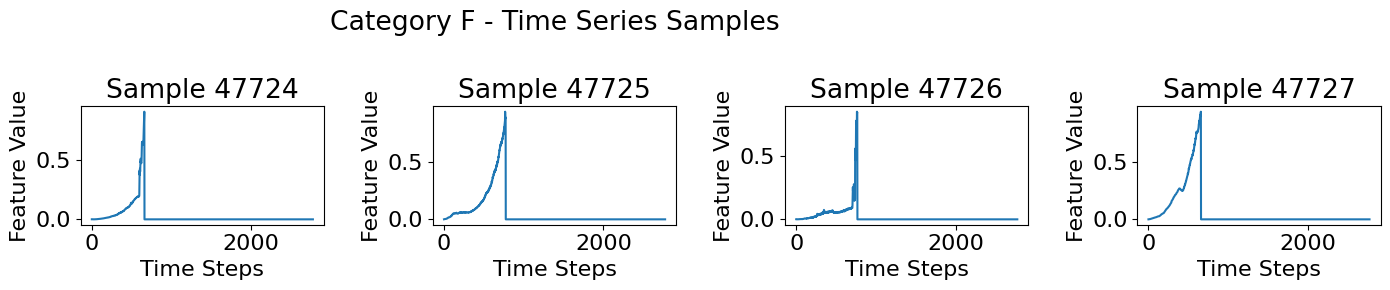

In [9]:
# Plot some samples
for category in "ABCDEF":
    to_be_inspected = 4

    plt.figure(figsize=(17, 3))  # Adjust the figure size as needed
    plt.suptitle(f'Category {category} - Time Series Samples')

    for idx in range(len(training_data)):
        if to_be_inspected == 0:
            break

        if categories[idx] != category:
            continue

        plt.subplot(1, 5, 6 - to_be_inspected)  # 1 row, 5 columns, and the current plot position
        plt.plot(training_data[idx])
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

        to_be_inspected -= 1

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()


<Figure size 1700x600 with 0 Axes>

<Figure size 1700x600 with 0 Axes>

<Figure size 1700x600 with 0 Axes>

<Figure size 1700x600 with 0 Axes>

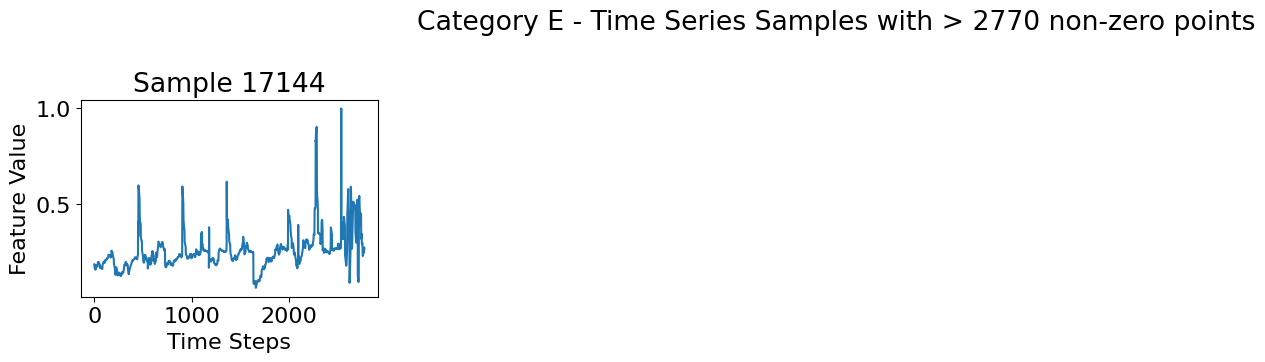

<Figure size 1700x600 with 0 Axes>

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the following data structures
# training_data: List of time series data
# categories: List of corresponding categories for each time series

# Function to count non-zero points in a time series
def count_nonzero_points(series):
    return np.count_nonzero(series != 0.0)

# Threshold for the number of points that differ from zero
threshold = 2770

# Plotting samples
for category in "ABCDEF":
    to_be_inspected = 10
    plt.figure(figsize=(17, 6))  # Adjust the figure size as needed
    plt.suptitle(f'Category {category} - Time Series Samples with > {threshold} non-zero points')

    for idx in range(len(training_data)):
        if to_be_inspected == 0:
            break

        if categories[idx] != category:
            continue

        current_series = training_data[idx]
        non_zero_count = count_nonzero_points(current_series)

        if non_zero_count <= threshold:
            continue

        plt.subplot(2, 5, 11 - to_be_inspected)  # 2 rows, 5 columns, and the current plot position
        plt.plot(current_series)
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

        to_be_inspected -= 1

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()
